사이토 고키, 2017, 한빛미디어, 밑바닥부터 시작하는 딥러닝 

In [1]:
import numpy as np
from util import show_image

## 오버피팅  
: 매개변수가 많고 표현력이 높은 모델   
: 훈련 데이터가 적을 때 

-> 가중치 감소 / 드롭아웃

### 가중치감소(weight decay)
\begin{equation*}
\text{hyperparmeter} \space\space \lambda \\
\frac{1}{2}\lambda\mathbf{W^2} \mapsto \text{Scalar} \\
\text{Forward} \quad Loss's \space output= Loss's \space output+\frac{1}{2}\lambda\mathbf{W^2} \ldots\ldots(1)\\
\text{Backward} \quad \space\mathbf{W} \gets \mathbf{W} - \eta(\frac{\partial\text{L}}{\partial\mathbf{W}}+\lambda\mathbf{W})\ldots\ldots(2) \\
\end{equation*}

In [2]:
"""
    가중치 감소(weight decay)
"""

def loss(self, x, t):
    """손실 함수를 구한다.

    Parameters
    ----------
    x : 입력 데이터
    t : 정답 레이블 

    Returns
    -------
    손실 함수의 값
    """
    y = self.predict(x)

    weight_decay = 0
    for idx in range(1, self.hidden_layer_num + 2):
        W = self.params['W' + str(idx)]
        weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2) # 식 (1)

    return self.last_layer.forward(y, t) + weight_decay # 식 (1)

def gradient(self, x, t):
    """기울기를 구한다(오차역전파법).

    Parameters
    ----------
    x : 입력 데이터
    t : 정답 레이블

    Returns
    -------
    각 층의 기울기를 담은 딕셔너리(dictionary) 변수
        grads['W1']、grads['W2']、... 각 층의 가중치
        grads['b1']、grads['b2']、... 각 층의 편향
    """
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
        dout = layer.backward(dout)

    # 결과 저장
    grads = {}
    for idx in range(1, self.hidden_layer_num+2):
        
        #식 (2)
        grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
        grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

    return grads

### 드롭아웃

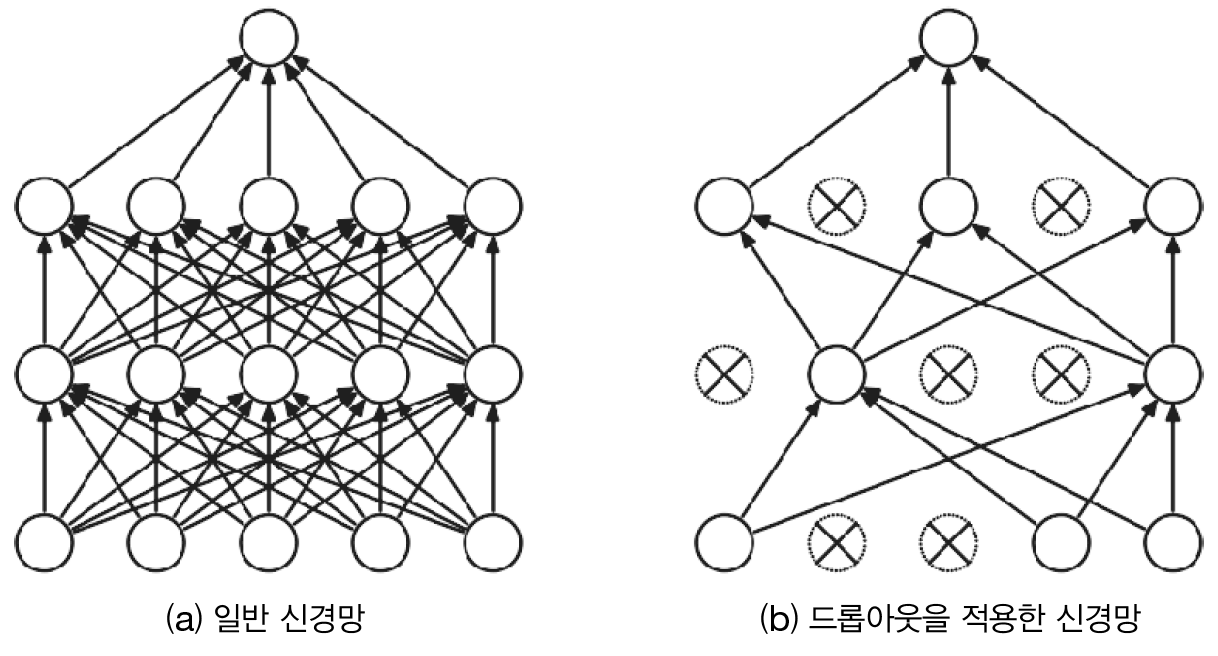

In [4]:
"""
    드롭아웃(Dropout)
    : 학습에선 뉴런을 임의로 제외 / 시험에선 모두 사용
    : 시험 때는 제외한 뉴런의 비율을 곱해서 출력
"""
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None #삭제할 노드 저장 변수
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask
show_image('fig 6-22.png',width=700)

### 하이퍼파라미터 탐색
하이퍼파라미터 최적화: 검증 데이터(Validation data) 사용
    
>훈련데이터 : 매개변수 학습(가중치&편향)  
검증데이터 : 하이퍼파라미터 성능 평가  
시험데이터 : 신경망의 범용 성능 평가  
    
>방법
>1. 하이퍼파라미터 값의 범위 설정 (보통 0.001 ~ 1,000 출발)  
    for__
    >>for__  
    1. 범위 내에서 무작위 추출  
    1. 검증 데이터로 정확도 평가  
>4. 정확도 분포를 보고 범위 축소